#!pip install mplfinance

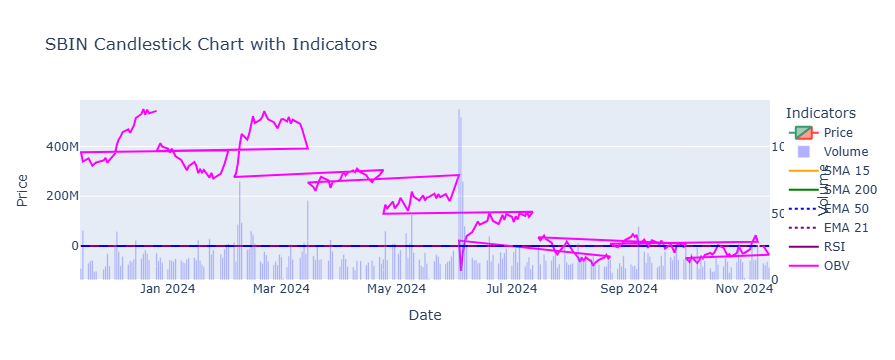

In [8]:
from nsepython import *
import plotly.graph_objects as go
import pandas as pd
import datetime

# Fetch historical data
end_date = datetime.datetime.now().strftime("%d-%m-%Y")
start_date = (datetime.datetime.now() - datetime.timedelta(days=365)).strftime("%d-%m-%Y")

symbol = "SBIN"  # Replace with your desired symbol
series = "EQ"

df = equity_history(symbol, series, start_date, end_date)

# Check if data is empty
if df.empty:
    print("No data available for the selected stock and date range.")
    exit()

# Prepare data
df['date'] = pd.to_datetime(df['CH_TIMESTAMP'])
df['close'] = df['CH_CLOSING_PRICE']
df['open'] = df['CH_OPENING_PRICE']
df['high'] = df['CH_TRADE_HIGH_PRICE']
df['low'] = df['CH_TRADE_LOW_PRICE']
df['volume'] = df['CH_TOT_TRADED_QTY']

# Calculate SMA (Simple Moving Average)
df['SMA_15'] = df['close'].rolling(window=15).mean()
df['SMA_200'] = df['close'].rolling(window=200).mean()

# Calculate EMA (Exponential Moving Average)
df['EMA_21'] = df['close'].ewm(span=21, adjust=False).mean()
df['EMA_50'] = df['close'].ewm(span=50, adjust=False).mean()

# Calculate RSI (Relative Strength Index)
delta = df['close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Calculate OBV (On-Balance Volume)
df['OBV'] = (df['volume'] * ((df['close'] > df['close'].shift(1)).astype(int) - (df['close'] < df['close'].shift(1)).astype(int))).cumsum()

# Create candlestick and volume bar chart
fig = go.Figure(data=[
    go.Candlestick(
        x=df['date'],
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        name='Price'
    ),
    go.Bar(
        x=df['date'],
        y=df['volume'],
        name='Volume',
        marker=dict(color='blue'),
        opacity=0.3,
        yaxis='y2'
    )
])

# Add SMA
fig.add_trace(go.Scatter(
    x=df['date'],
    y=df['SMA_15'],
    mode='lines',
    name='SMA 15',
    line=dict(color='orange')
))

fig.add_trace(go.Scatter(
    x=df['date'],
    y=df['SMA_200'],
    mode='lines',
    name='SMA 200',
    line=dict(color='green')
))

# Add EMA
fig.add_trace(go.Scatter(
    x=df['date'],
    y=df['EMA_50'],
    mode='lines',
    name='EMA 50',
    line=dict(color='blue', dash='dot')
))

fig.add_trace(go.Scatter(
    x=df['date'],
    y=df['EMA_21'],
    mode='lines',
    name='EMA 21',
    line=dict(color='purple', dash='dot')
))

# Add RSI
fig.add_trace(go.Scatter(
    x=df['date'],
    y=df['RSI'],
    mode='lines',
    name='RSI',
    line=dict(color='purple')
))

# Add OBV
fig.add_trace(go.Scatter(
    x=df['date'],
    y=df['OBV'],
    mode='lines',
    name='OBV',
    line=dict(color='magenta')
))

# Update layout to include secondary y-axis for volume
fig.update_layout(
    title=f'{symbol} Candlestick Chart with Indicators',
    xaxis_title='Date',
    yaxis_title='Price',
    yaxis2=dict(
        title='Volume',
        overlaying='y',
        side='right',
        showgrid=False
    ),
    xaxis_rangeslider_visible=False,
    legend_title='Indicators'
)

# Add RSI overbought and oversold thresholds
fig.add_shape(
    type="line",
    x0=df['date'].min(),
    y0=70,
    x1=df['date'].max(),
    y1=70,
    line=dict(color="red", dash="dash"),
    xref='x',
    yref='y'
)

fig.add_shape(
    type="line",
    x0=df['date'].min(),
    y0=30,
    x1=df['date'].max(),
    y1=30,
    line=dict(color="blue", dash="dash"),
    xref='x',
    yref='y'
)

# Show the chart
fig.show()
